# Embeddings, Self-Attention y Decoders

Este notebook explica conceptos clave de los modelos de lenguaje:

1. **Embeddings:** Representaciones numéricas de palabras.
2. **Self-Attention:** Relación entre palabras en una oración.
3. **Decoder:** Generación de texto.

## 1. Instalación y Configuración de Librerías

In [1]:
!pip install transformers torch matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Importación de Librerías Necesarias

In [2]:
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel

C:\Users\PC MASTER\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Embeddings: Representación Numérica de Palabras
Los embeddings convierten palabras en vectores de alta dimensionalidad que capturan su significado semántico.


In [3]:
# Cargamos un modelo preentrenado y su tokenizador.
MODEL_NAME = "bert-base-uncased"  # Modelo BERT como ejemplo.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

In [4]:
# Texto de ejemplo.
text = "Machine learning is fascinating."

# Tokenizamos el texto y obtenemos los IDs de los tokens.
inputs = tokenizer(text, return_tensors="pt", add_special_tokens=True)
input_ids = inputs["input_ids"]

# Generamos los embeddings con el modelo.
with torch.no_grad():
    outputs = model(**inputs)

# Los embeddings están en la primera capa oculta del modelo.
embeddings = outputs.last_hidden_state

print("Forma de los embeddings:", embeddings.shape)

Forma de los embeddings: torch.Size([1, 7, 768])


### Visualización de Embeddings

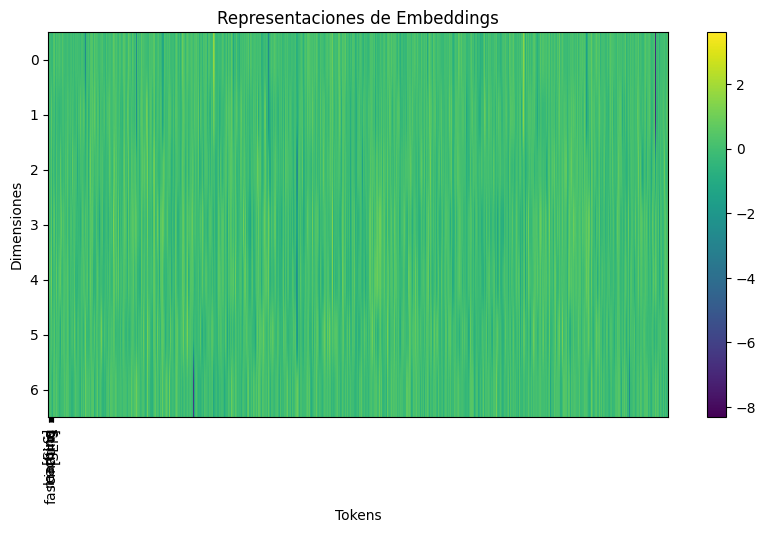

In [5]:
# Mostramos los embeddings en forma de gráfico de calor.
def plot_embeddings(embedding_matrix, tokens):
    plt.figure(figsize=(10, 5))
    plt.imshow(embedding_matrix, aspect="auto", cmap="viridis")
    plt.colorbar()
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.xlabel("Tokens")
    plt.ylabel("Dimensiones")
    plt.title("Representaciones de Embeddings")
    plt.show()

# Extraemos los embeddings de las palabras y las convertimos a numpy.
embedding_matrix = embeddings[0].detach().numpy()

# Obtenemos los tokens asociados.
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Visualizamos.
plot_embeddings(embedding_matrix, tokens)

### Reducción de Dimensiones
Se pueden utilizar técnicas como PCA (Análisis de Componentes Principales) o t-SNE para reducir las dimensiones de los embeddings a 2 o 3, y luego visualizar los resultados de manera más clara.

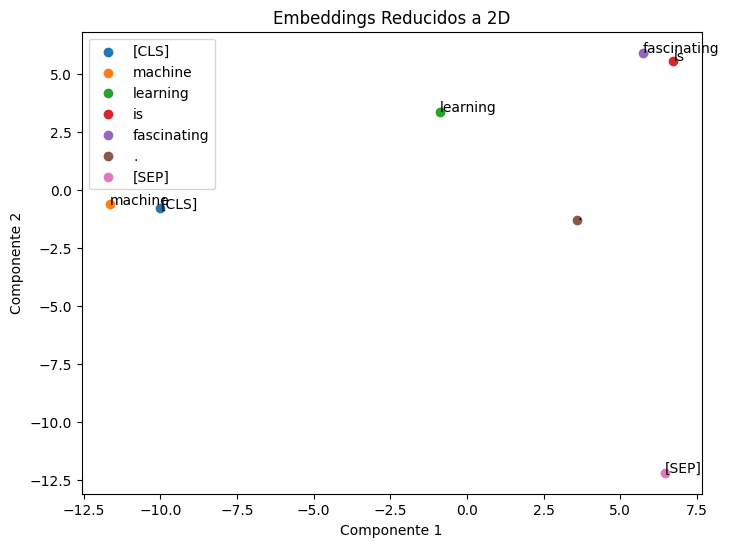

In [6]:
from sklearn.decomposition import PCA
import numpy as np

# Reducimos los embeddings a 2 dimensiones usando PCA.
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_matrix)

# Graficamos las representaciones en 2D.
plt.figure(figsize=(8, 6))
for i, token in enumerate(tokens):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=token)
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], token, fontsize=10)

plt.title("Embeddings Reducidos a 2D")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend()
plt.show()


## Normalización de Valores
Los valores en los embeddings pueden variar ampliamente, lo que hace que el gráfico de calor sea difícil de interpretar. Normalizarlos entre 0 y 1 puede mejorar la visualización.

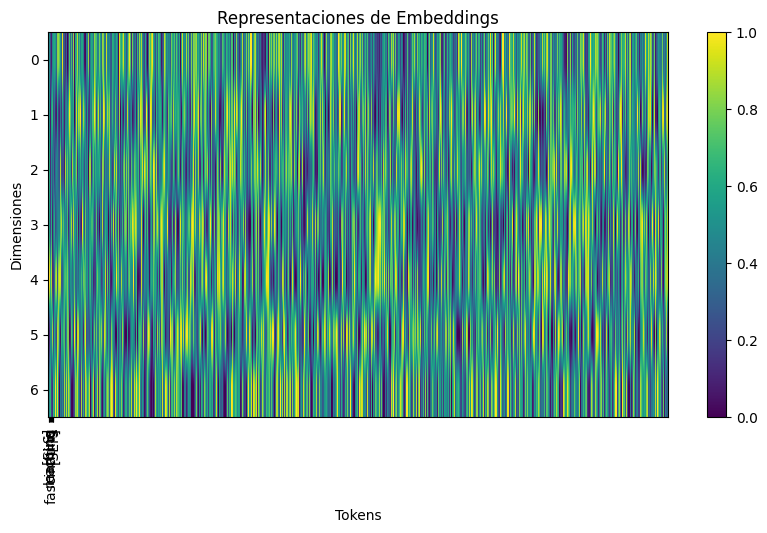

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Normalizamos los valores de los embeddings.
scaler = MinMaxScaler()
normalized_embeddings = scaler.fit_transform(embedding_matrix)

# Volvemos a graficar con los valores normalizados.
plot_embeddings(normalized_embeddings, tokens)


## Selección de Dimensiones Clave
En lugar de visualizar todas las dimensiones, se pueden mostrar solo las más relevantes (por ejemplo, las primeras 10).

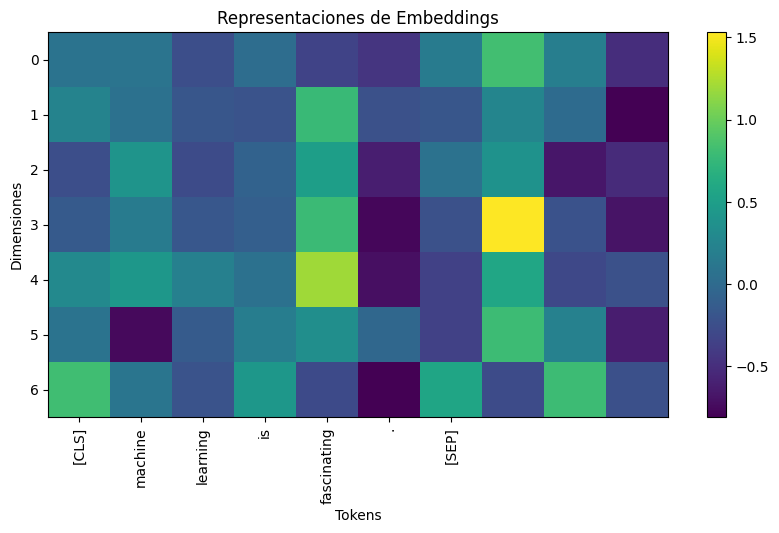

In [8]:
# Seleccionamos las primeras 10 dimensiones de los embeddings.
selected_dimensions = embedding_matrix[:, :10]

# Mostramos el gráfico de calor solo para estas dimensiones.
plot_embeddings(selected_dimensions, tokens)


## 4. Self-Attention: Relación entre Palabras

Self-Attention permite a los modelos ponderar la importancia de cada palabra en relación con las demás.

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


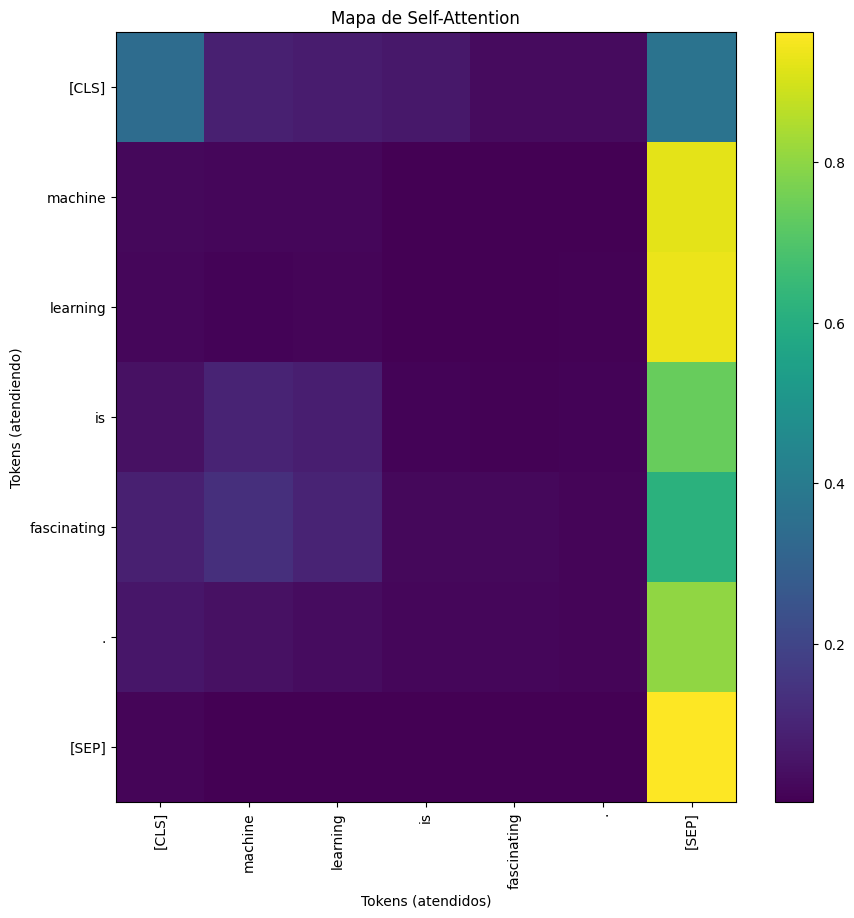

In [9]:
from transformers import BertModel

# Modelo BERT ya cargado.
bert_model = BertModel.from_pretrained(MODEL_NAME, output_attentions=True)

# Obtenemos las atenciones del modelo.
with torch.no_grad():
    outputs = bert_model(**inputs)

# Las atenciones se encuentran en `attentions`.
attentions = outputs.attentions  # Lista de tensores (número de capas, batch, cabezas, tokens, tokens).

# Visualizamos las atenciones de la última capa y primera cabeza.
def plot_attention(attention_matrix, tokens):
    plt.figure(figsize=(10, 10))
    plt.imshow(attention_matrix, aspect="auto", cmap="viridis")
    plt.colorbar()
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.yticks(range(len(tokens)), tokens)
    plt.xlabel("Tokens (atendidos)")
    plt.ylabel("Tokens (atendiendo)")
    plt.title("Mapa de Self-Attention")
    plt.show()

# Extraemos la matriz de atención de la última capa y primera cabeza.
attention_matrix = attentions[-1][0][0].numpy()

# Visualizamos.
plot_attention(attention_matrix, tokens)

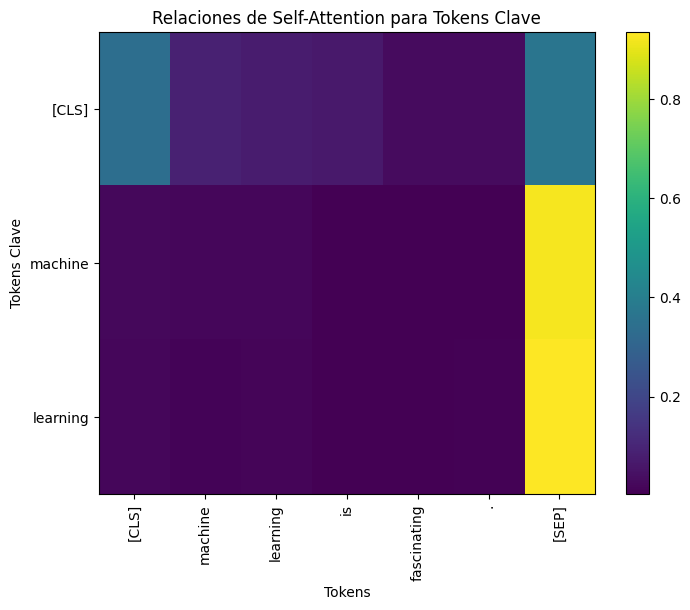

In [10]:
# Tokens clave (por ejemplo, las primeras 3 palabras).
key_tokens = [0, 1, 2]  # Índices de tokens clave.

# Extraemos solo las relaciones relevantes.
key_attention_matrix = attention_matrix[key_tokens, :]
plt.figure(figsize=(8, 6))
plt.imshow(key_attention_matrix, aspect="auto", cmap="viridis")
plt.colorbar()
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(key_tokens)), [tokens[i] for i in key_tokens])
plt.title("Relaciones de Self-Attention para Tokens Clave")
plt.xlabel("Tokens")
plt.ylabel("Tokens Clave")
plt.show()


## 5. Decoder: Generación de Texto

Los decoders generan texto utilizando los embeddings y las relaciones aprendidas por el modelo.

In [ ]:
from transformers import AutoModelForCausalLM

# Cargamos un modelo de decodificación (e.g., GPT-2).
MODEL_NAME = "gpt2"
decoder_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
decoder_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Texto de entrada (prompt).
prompt = "Artificial intelligence will"
input_ids = decoder_tokenizer(prompt, return_tensors="pt").input_ids

# Generación de texto.
generated_output = decoder_model.generate(
    input_ids,
    max_length=50,
    temperature=0.7,
    top_k=50,
    do_sample=True
)

# Decodificamos el texto generado.
output_text = decoder_tokenizer.decode(generated_output[0], skip_special_tokens=True)

print("Texto generado:", output_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


## 6. Conclusiones

- **Embeddings:** Capturan significado semántico.
- **Self-Attention:** Modelan relaciones contextuales entre palabras.
- **Decoder:** Transforma embeddings y relaciones en texto coherente.